<a href="https://colab.research.google.com/github/marcusborela/Aprendizado-Profundo-Unicamp/blob/main/Analise_Imagens_Satelite__Explorando_as_Redes_Convolucionais_em_Vis%C3%A3o_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explorando as Redes Convolucionais em Visão Computacional

## Remis Balaniuk, PhD




## Treinando uma convnet do zero em um pequeno conjunto de dados

### A relevância do aprendizado profundo para problemas com poucos dados

É comum afirmarem que o aprendizado profundo só funciona quando muitos dados estão disponíveis.
Isso é válido em parte: uma característica fundamental da aprendizagem profunda é que ela pode encontrar
características interessantes nos dados de treinamento por si só, sem qualquer necessidade de engenharia de recurso manual, e isso só pode ser alcançado quando muitos exemplos de treinamento são
disponibilizados. Isso é especialmente verdadeiro para problemas em que as amostras de entrada têm dimensões muito altas, como imagens.
 
Mas o que constitui muitas amostras é relativo - em relação ao tamanho e profundidade da
rede que você está tentando treinar, para começar. Não é possível treinar um convnet para resolver um
problema complexo com apenas algumas dezenas de amostras, mas algumas centenas podem potencialmente
bastar se o modelo for pequeno e bem regularizado e a tarefa for simples. 

Como as redes convolucionais aprendem características locais invariáveis ​​à localização, são altamente eficientes em problemas de percepção em termos da quantidade de dados. Treinar um convnet do zero em um conjunto de dados de imagem muito pequeno ainda
produzem resultados razoáveis, apesar da relativa falta de dados, sem a necessidade de qualquer customização ou
engenharia de atributos. 

Você verá isso em ação nesta seção.
 Além do mais, os modelos de aprendizado profundo são por natureza altamente reaproveitáveis: você pode usar, digamos, uma classificação de imagem ou modelo de fala para texto treinado em um conjunto de dados em grande escala
e reutilizá-lo em um problema significativamente diferente com apenas pequenas alterações. 

Especificamente, no caso da visão computacional, muitos modelos pré-treinados (geralmente treinados no conjunto de dados Image Net) estão agora disponíveis publicamente para download e podem ser usados ​​para inicializar modelos de visão poderosos a partir de poucos dados. Isso é o que você fará na próxima seção. 

Vamos
começar acessando os dados.

### Download dos dados

O conjunto de dados Dogs vs. Cats que você usará não vem com Keras. Foi disponibilizado no Kaggle como parte de uma competição de visão computacional no final de 2013, quando
Convnets não eram ainda tão populares. Você pode baixar o conjunto de dados original em www.kaggle.com/c/dogs-vs-cats/data (você precisará criar uma conta Kaggle, se ainda não tiver).

![](https://www.programmersought.com/images/940/0a41e3c09023853ed1441a2b0cef7cec.png)

## Instruções para acesso ao diretório de imagens

Acesse o link do diretório no browser:

https://drive.google.com/drive/folders/1RqdqxUsGe4gOZv2iqWm-p16_8bsuPrdM?usp=sharing 

Na parte superior da tela, onde aparece o caminho do acesso, clique em "dogs-and-cats" com o botão direito do mouse e escolha "Adicionar atalho ao Google Drive". Verifique a raiz do seu drive e veja se apareceu um link com esse nome.

Em seguida monte seu drive aqui no Colab.

In [1]:
import os, shutil, pathlib 
from os import listdir
from os.path import isfile, join

new_base_dir = pathlib.Path("drive/MyDrive/dogs-and-cats/")

In [33]:
path_curso = "drive/MyDrive/curso_analise_imagens_satelite"

**Inspecionando a base**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
imgs = pathlib.Path("drive/MyDrive/dogs-and-cats/train/cat")
arqs = [f for f in listdir(imgs) if isfile(join(imgs, f))]

In [5]:
len(arqs)

1000

In [6]:
arqs[:3]

['cat.10378.jpg', 'cat.10377.jpg', 'cat.10385.jpg']

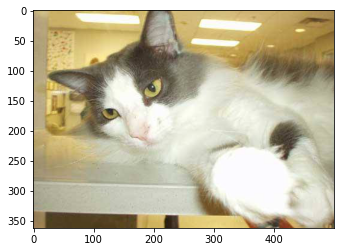

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image # https://pillow.readthedocs.io/en/stable/reference/Image.html
img = Image.open("drive/MyDrive/dogs-and-cats/train/cat/cat.10378.jpg")
plt.imshow(img)

In [8]:
img.getbands()

('R', 'G', 'B')

In [9]:
vals = list(img.getdata(band=0))

In [10]:
vals[:10]

[181, 182, 184, 186, 188, 191, 192, 193, 201, 200]

# Explicando melhor os datasets no Tensorflow

Os conjuntos de dados nativos do TensorFlow são prontos para uso com o TensorFlow ou outras estruturas de ML do Python. Todos os conjuntos de dados são expostos como tf.data.Datasets, o que permite pipelines de entrada fáceis de usar e de alto desempenho. 

Mas se seus dados provêm de uma fonte externa será preciso transformá-los em datasets. Os dados devem ser formatados em tensores de pontos flutuantes devidamente pré-processados antes de serem alimentados na rede.

A API tf.data.Dataset suporta a escrita de pipelines de entrada descritivos e eficientes. O uso do conjunto de dados segue um padrão comum:

- Crie um conjunto de dados de origem a partir de seus dados de entrada.

- Aplique transformações de conjunto de dados para pré-processar os dados.

- Repita o conjunto de dados e processe os elementos.

A iteração ocorre em um fluxo contínuo, portanto, o conjunto de dados completo não precisa caber na memória.

Explicaremos algumas situações típicas antes de carregar as imagens do nosso exemplo.



**Instanciando um Dataset a partir de um NumPy array**

Nesse exemplo mostramos como criar um dataset diretamente de um array Numpy usando o tf.data.Dataset.from_tensor_slices.

In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
random_numbers.shape

(1000, 16)

In [13]:
random_numbers[:3]

array([[-0.62735616,  1.00039977, -0.09561489,  0.27704004,  0.80581371,
         0.98789996, -0.55377327, -0.54611581,  0.70046283, -0.87605262,
        -0.41451964,  0.92998994,  0.14349344, -0.04804462,  0.48389486,
        -1.50893164],
       [ 0.05814287,  1.64345512, -0.52012606,  0.11294103, -1.30815516,
         0.13673857, -0.64068678,  0.84545864, -0.89159525,  1.36135989,
        -0.95176772,  0.37491079, -1.39631809,  0.16385699,  1.44463755,
         0.55944613],
       [ 1.25878753,  0.22496608,  0.06928055, -1.29937487,  0.50585752,
         0.63921265, -0.09036328,  0.46364175,  2.35806662, -1.42310432,
        -0.49335087,  0.6419449 ,  0.3705437 ,  1.54247981,  0.53848009,
        -0.76615726]])

In [14]:
len(dataset)

1000

**Iterando no dataset**

In [15]:
for i, element in enumerate(dataset):
    print(i,element)
    if i >= 2:
        break

0 tf.Tensor(
[-0.62735616  1.00039977 -0.09561489  0.27704004  0.80581371  0.98789996
 -0.55377327 -0.54611581  0.70046283 -0.87605262 -0.41451964  0.92998994
  0.14349344 -0.04804462  0.48389486 -1.50893164], shape=(16,), dtype=float64)
1 tf.Tensor(
[ 0.05814287  1.64345512 -0.52012606  0.11294103 -1.30815516  0.13673857
 -0.64068678  0.84545864 -0.89159525  1.36135989 -0.95176772  0.37491079
 -1.39631809  0.16385699  1.44463755  0.55944613], shape=(16,), dtype=float64)
2 tf.Tensor(
[ 1.25878753  0.22496608  0.06928055 -1.29937487  0.50585752  0.63921265
 -0.09036328  0.46364175  2.35806662 -1.42310432 -0.49335087  0.6419449
  0.3705437   1.54247981  0.53848009 -0.76615726], shape=(16,), dtype=float64)


**Quebrando o dataset em batches**

O treinamento da rede é feito em lotes, o que requer a quebra da base inicial nesses lotes. Nesse exemplo quebraremos nosso dataset de 1000 tensores em lotes de tamanho 32.

In [16]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [17]:
len(batched_dataset)

32

**Aplicando uma transformação aos elementos do conjunto de dados usando `map()`**

Supondo que nossos dados, de tamanho 16, são imagens de 4x4 pixels, podemos reformata-los usando um reshape e a função map.

In [18]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [19]:
len(reshaped_dataset)

1000

### Carga das imagens

Como você já sabe, os dados devem ser formatados em tensores de pontos flutuantes devidamente pré-processados antes de serem alimentados na rede. 

Inicialmente, nossos dados estão em uma unidade de disco enquanto arquivos JPEG, portanto, as etapas para colocá-los na rede são as seguintes:

- 1 Leia os arquivos de imagem.

- 2 Decodifique o conteúdo JPEG em grades RGB de pixels.

- 3 Converta-os em tensores de ponto flutuante.

- 4 Redimensione os valores de pixel (entre 0 e 255) para o intervalo [0, 1] (como você sabe,
redes neurais preferem lidar com pequenos valores de entrada).

Felizmente Keras tem utilitários para cuidar desses
passos automaticamente. 

Keras tem um módulo com ferramentas auxiliares de processamento de imagem, localizado em
keras.preprocessing.image. Em particular, ele contém a classe image_dataset_from_directory,
que permite carregar e transformar arquivos de imagem automaticamente
no disco em lotes de tensores pré-processados. Isso é o que usaremos aqui.

**Usando o `image_dataset_from_directory` para ler as imagens do Drive**

In [20]:
new_base_dir

PosixPath('drive/MyDrive/dogs-and-cats')

In [21]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [39]:
batch_size = 256

In [40]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=batch_size)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=batch_size)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Temos 2.000 imagens de treinamento, 1.000 imagens de validação e 1.000 de teste. Cada divisão contém o mesmo número de amostras de cada classe: este é um problema de classificação binária, o que significa que a precisão da classificação será um
medida apropriada de sucesso.

In [23]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

**Exibindo as formas dos dados e rótulos produzidos pelo Dataset**

In [24]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [25]:
labels_batch[1]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

### Definindo o modelo

**Instanciando uma pequena convnet para classificação de cães vs. gatos**

Construimos uma pequena convnet para MNIST no caderno anterior, então você deve estar familiarizado
com tais convnets. Você vai reutilizar a mesma estrutura geral: a convnet será uma
pilha de Conv2D alternadas (com ativação relu) e camadas MaxPooling2D.

Mas porque você está lidando com imagens maiores e um problema mais complexo, aumentaremos a sua rede, de acordo: ela terá mais uma etapa Conv2D + MaxPooling2D. 

Isso serve para aumentar a capacidade da rede e para reduzir ainda mais
o tamanho dos mapas de feições para que não sejam excessivamente grandes quando chegarmos à camada Flatten. 

Aqui, porque você começa com entradas de tamanho 180 × 180 (shape das imagens), você acaba com mapas de features de tamanho 7 × 7 antes da camada Flatten.

In [26]:
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:

inputs = keras.Input(shape=(180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)  # normalizando os tensores
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)  
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configurando o modelo para treinamento**

In [28]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Treinando o modelo usando o Dataset**

In [29]:
# pode ser lento
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 143s 2s/step - loss: 0.7599 - accuracy: 0.5110 - val_loss: 0.6903 - val_accuracy: 0.5510
Epoch 2/20
63/63 [==============================] - 5s 69ms/step - loss: 0.7027 - accuracy: 0.5410 - val_loss: 0.6767 - val_accuracy: 0.5730
Epoch 3/20
63/63 [==============================] - 4s 63ms/step - loss: 0.6747 - accuracy: 0.5885 - val_loss: 0.6553 - val_accuracy: 0.6210
Epoch 4/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6522 - accuracy: 0.6635 - val_loss: 0.7434 - val_accuracy: 0.5760
Epoch 5/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6060 - accuracy: 0.6755 - val_loss: 1.0742 - val_accuracy: 0.5680
Epoch 6/20
63/63 [==============================] - 4s 62ms/step - loss: 0.5925 - accuracy: 0.6960 - val_loss: 0.5975 - val_accuracy: 0.6850
Epoch 7/20
63/63 [==============================] - 4s 62ms/step - loss: 0.5600 - accuracy: 0.7275 - val_loss: 0.5917 - val_accuracy: 0.6920
Epoch 8/20
63

**Exibindo curvas de perda e precisão durante o treinamento**

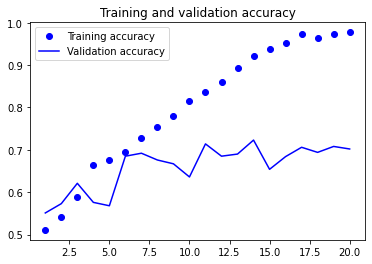

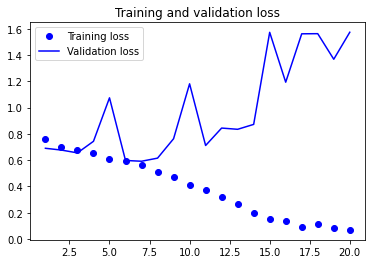

In [30]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Avaliação do modelo no conjunto de teste**

In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

63/63 [==============================] - 115s 2s/step - loss: 1.5058 - accuracy: 0.7110


In [36]:
test_loss, test_acc

(1.5058261156082153, 0.7110000252723694)

In [31]:
%pwd

'/content'

In [34]:
 keras.models.save_model(model,path_curso)

INFO:tensorflow:Assets written to: drive/MyDrive/curso_analise_imagens_satelite/assets


In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 754s 10s/step - loss: 0.5713 - accuracy: 0.7010
Test accuracy: 0.701


Esses gráficos são característicos de sobreajuste. A precisão do treinamento aumenta linearmente
ao longo do tempo, até atingir quase 100%, enquanto a precisão da validação para em 70-72%.
A perda de validação atinge seu mínimo após apenas cinco épocas e, em seguida, para, enquanto
a perda de treinamento continua diminuindo linearmente até chegar perto de 0.
Porque você tem relativamente poucas amostras de treinamento (2.000), overfitting será sua
preocupação número um. 

Você já conhece várias técnicas que podem ajudar
mitigar overfitting, como abandono e queda de peso (regularização L2). 

Vamos agora explorar com uma nova estratégia, específica para visão computacional e usada quase universalmente
ao processar imagens com modelos de aprendizagem profunda: aumento de dados.

### Tentando problema de regularização  com dropout

**Definindo uma nova convnet que inclui aumento de imagem e dropout**

Se você treinar uma nova rede usando esta configuração de aumento de dados, a rede
nunca verá a mesma entrada duas vezes. Mas as entradas que ele vê ainda estão fortemente correlacionadas,
porque eles vêm de um pequeno número de imagens originais - você não pode produzir
novas informações, você só pode remixar informações existentes. 

Como tal, isso não pode
ser suficiente para se livrar completamente do overfitting. Para combater ainda mais o overfitting, você pode também
adicionar uma camada Dropout ao seu modelo, logo antes do classificador densamente conectado.


In [42]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Treinando a convnet regularizada**

O ideal aqui seria treinar com mais épocas (~100) pois a regularização torna o processo de convergência mais lento.

Mas devido a limites de tempo na aula rodaremos só 20 épocas.

In [43]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20, # tente com 100
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
8/8 [==============================] - 15s 1s/step - loss: 1.3113 - accuracy: 0.5070 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 6s 481ms/step - loss: 0.6910 - accuracy: 0.5240 - val_loss: 0.6995 - val_accuracy: 0.5020
Epoch 3/20
8/8 [==============================] - 6s 483ms/step - loss: 0.6899 - accuracy: 0.5315 - val_loss: 1.0251 - val_accuracy: 0.5000
Epoch 4/20
8/8 [==============================] - 6s 487ms/step - loss: 0.7185 - accuracy: 0.5040 - val_loss: 0.6891 - val_accuracy: 0.5290
Epoch 5/20
8/8 [==============================] - 6s 485ms/step - loss: 0.6932 - accuracy: 0.5180 - val_loss: 0.6902 - val_accuracy: 0.5840
Epoch 6/20
8/8 [==============================] - 6s 487ms/step - loss: 0.6926 - accuracy: 0.5285 - val_loss: 0.6895 - val_accuracy: 0.5890
Epoch 7/20
8/8 [==============================] - 6s 485ms/step - loss: 0.6868 - accuracy: 0.5550 - val_loss: 0.6999 - val_accuracy: 0.5570
Epoch 8/20
8/8 [======

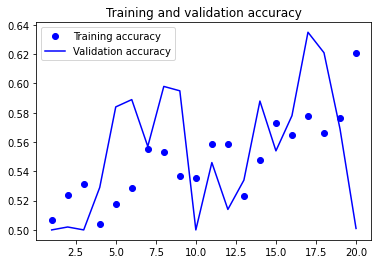

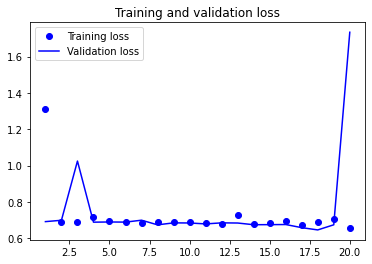

In [44]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Avaliação do modelo no conjunto de teste**

In [45]:
test_model = keras.models.load_model(
    "convnet_from_scratch_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 3s 126ms/step - loss: 0.6569 - accuracy: 0.6325
Test accuracy: 0.632


Usando técnicas de regularização ainda mais, e ajustando os parâmetros da rede
(como o número de filtros por camada de convolução, ou o número de camadas em
da rede), você poderá obter uma precisão ainda melhor, provavelmente de até 86% ou 87%.

Mas seria difícil ir mais alto apenas treinando sua própria convnet do zero, porque você tem tão poucos dados para trabalhar. Como próximo passo para melhorar sua
precisão neste problema, você terá que usar um modelo pré-treinado.

### Usando data augmentation

O aumento de dados adota a abordagem de gerar mais dados de treinamento
a partir de amostras de treinamento existentes, aumentando as amostras por meio de uma série de
transformações que geram imagens de aparência convincente. 

O objetivo é que na hora do treinamento,
seu modelo nunca verá exatamente a mesma imagem duas vezes. Isso ajuda a expor o modelo
para mais aspectos dos dados e generalizar melhor.

No Keras, isso pode ser feito configurando uma série de transformações aleatórias para
ser executado nas imagens lidas pela instância ImageDataGenerator. Vamos pegar
começou com um exemplo.

**Definido um estágio de aumento de dados para adicionar a um modelo de imagem**

In [46]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

**Exibindo algumas imagens de treinamento aumentadas aleatoriamente**

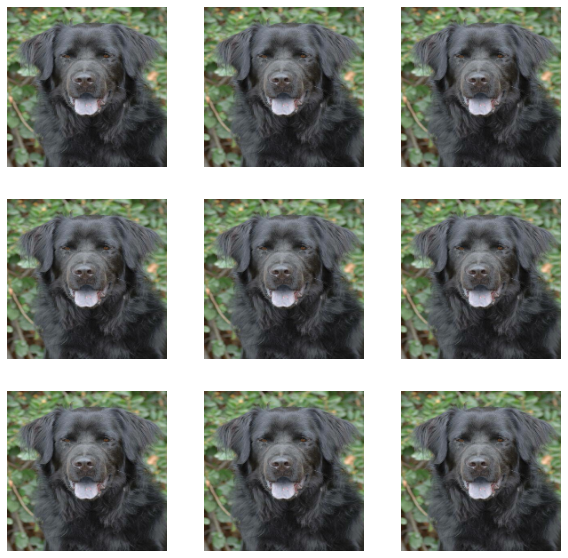

In [47]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Usando data augmentation

Vamos agora explorar com uma nova estratégia, específica para visão computacional e usada quase universalmente
ao processar imagens com modelos de aprendizagem profunda: aumento de dados.

O aumento de dados adota a abordagem de gerar mais dados de treinamento
a partir de amostras de treinamento existentes, aumentando as amostras por meio de uma série de
transformações que geram imagens de aparência convincente. 

O objetivo é que na hora do treinamento,
seu modelo nunca verá exatamente a mesma imagem duas vezes. Isso ajuda a expor o modelo
para mais aspectos dos dados e generalizar melhor.

No Keras, isso pode ser feito configurando uma série de transformações aleatórias para
ser executado nas imagens lidas pela instância ImageDataGenerator. Vamos pegar
começou com um exemplo.

**Definido um estágio de aumento de dados para adicionar a um modelo de imagem**

In [48]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

In [49]:
def augment(img):
    data_augmentation = tf.keras.Sequential([
              tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
              tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
             ])    
    return data_augmentation(img)



In [50]:
# generate 10 images 8x8 RGB
data = np.random.randint(0,255,size=(10, 8, 8, 3))

dataset = tf.data.Dataset.from_tensor_slices(data).batch(5)

for d in dataset:
  aug_d = augment(d)

**Exibindo algumas imagens de treinamento aumentadas aleatoriamente**

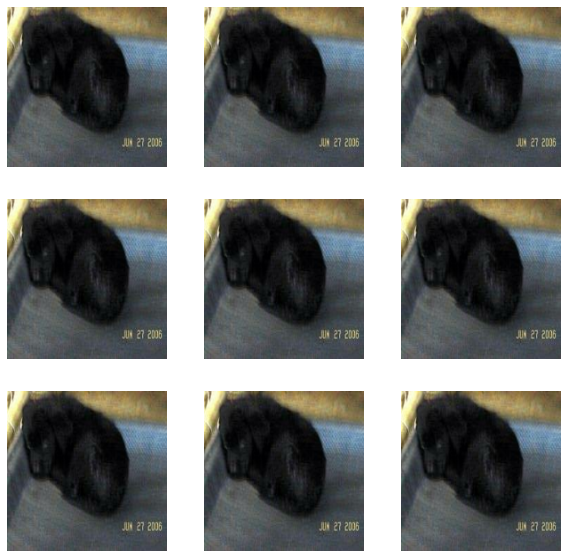

In [51]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(8):
        augmented_images = augment(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
    ax = plt.subplot(3, 3, 9)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")

**Definindo uma nova convnet que inclui aumento de imagem e dropout**

Se você treinar uma nova rede usando esta configuração de aumento de dados, a rede
nunca verá a mesma entrada duas vezes. Mas as entradas que ele vê ainda estão fortemente correlacionadas,
porque eles vêm de um pequeno número de imagens originais - você não pode produzir
novas informações, você só pode remixar informações existentes. 

Como tal, isso não pode
ser suficiente para se livrar completamente do overfitting. Para combater ainda mais o overfitting, você pode também
adicionar uma camada Dropout ao seu modelo, logo antes do classificador densamente conectado.


In [52]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Treinando a convnet regularizada**

O ideal aqui seria treinar com mais épocas (~100) pois a regularização torna o processo de convergência mais lento.

Mas devido a limites de tempo na aula rodaremos só 20 épocas.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=40, # tente com 100
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
8/8 [==============================] - 7s 508ms/step - loss: 0.8650 - accuracy: 0.4970 - val_loss: 0.7323 - val_accuracy: 0.5000
Epoch 2/40
8/8 [==============================] - 6s 495ms/step - loss: 0.7012 - accuracy: 0.5040 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 3/40
8/8 [==============================] - 6s 492ms/step - loss: 0.6917 - accuracy: 0.5240 - val_loss: 0.6884 - val_accuracy: 0.6120
Epoch 4/40
8/8 [==============================] - 6s 486ms/step - loss: 0.6930 - accuracy: 0.5285 - val_loss: 0.7763 - val_accuracy: 0.5000
Epoch 5/40
8/8 [==============================] - 6s 488ms/step - loss: 0.6997 - accuracy: 0.5100 - val_loss: 0.6805 - val_accuracy: 0.5770
Epoch 6/40
8/8 [==============================] - 6s 480ms/step - loss: 0.8146 - accuracy: 0.5745 - val_loss: 0.6809 - val_accuracy: 0.5710
Epoch 7/40
8/8 [==============================] - 6s 481ms/step - loss: 0.6742 - accuracy: 0.5930 - val_loss: 0.6849 - val_accuracy: 0.5440
Epoch 8/40
8/8 [====

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Avaliação do modelo no conjunto de teste**

In [ ]:
# carregando do checkpoint
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Usando técnicas de regularização ainda mais, e ajustando os parâmetros da rede
(como o número de filtros por camada de convolução, ou o número de camadas em
da rede), você poderá obter uma precisão ainda melhor, provavelmente de até 86% ou 87%.

Mas seria difícil ir mais alto apenas treinando sua própria convnet do zero, porque você tem tão poucos dados para trabalhar. Como próximo passo para melhorar sua
precisão neste problema, você terá que usar um modelo pré-treinado.

## Aproveitando um modelo pré-treinado

Uma abordagem comum e altamente eficaz para aprendizado profundo em conjuntos pequenos de dados de imagens é usar uma rede pré-treinada. 

Uma rede pré-treinada é uma rede salva que foi anteriormente
treinada em um grande conjunto de dados, normalmente em uma tarefa de classificação de imagens em grande escala. 

Se este
conjunto de dados original é grande o suficiente e geral o suficiente, então a hierarquia espacial de recursos
aprendido pela rede pré-treinada pode efetivamente atuar como um modelo genérico do
mundo visual e, portanto, seus recursos podem ser úteis para muitos serviços de computação diferentes
problemas, mesmo que esses novos problemas possam envolver classes completamente diferentes do que aquelas da tarefa original. 

Por exemplo, você pode treinar uma rede em
ImageNet (onde as classes são principalmente animais e objetos do cotidiano) e, em seguida, reaproveitar
esta rede treinada para algo tão remoto como identificar itens de móveis em
imagens. 

Essa portabilidade de recursos aprendidos em diferentes problemas é uma vantagem chave
de aprendizagem profunda em comparação com muitas abordagens de aprendizagem superficiais mais antigas, e
torna o aprendizado profundo muito eficaz para problemas de dados pequenos.

Neste caso, vamos considerar um grande convnet treinado no conjunto de dados ImageNet
(1,4 milhões de imagens rotuladas e 1.000 classes diferentes). ImageNet contém muitos animais
classes, incluindo diferentes espécies de cães e gatos, e você pode esperar
ter um bom desempenho no problema de classificação de cães versus gatos.

Você usará a arquitetura VGG16, desenvolvida por Karen Simonyan e Andrew
Zisserman em 2014; é uma arquitetura convnet simples e amplamente usada para ImageNet.

Embora seja um modelo mais antigo, longe do estado da arte atual e um pouco
mais pesado do que muitos outros modelos recentes, eu o escolhi porque sua arquitetura é semelhante a
o que você já conhece e é fácil de entender, sem a introdução de nenhum
novos conceitos. 

Este pode ser seu primeiro encontro com um desses modelos famosos, tais como a VGG, ResNet, Inception, Inception-ResNet, Xception e assim por diante; você acabará se
habituando a eles, porque eles surgirão com frequência se você continuar fazendo o aprendizado profundo
para visão computacional.

Existem duas maneiras de usar uma rede pré-treinada: extração de características e ajuste fino.

Vamos cobrir os dois. Vamos começar com a extração de recursos.

### Extração de características com um modelo pré-treinado

**Instanciando a VGG16**

Você passa três argumentos para o construtor:

-weights especifica o ponto de verificação de peso a partir do qual inicializar o modelo.

- include_top refere-se a incluir (ou não) o classificador densamente conectado no topo da rede. Por padrão, este classificador densamente conectado corresponde a
as 1.000 classes da ImageNet. Porque você pretende usar o seu próprio classificador densamente
 conectado (com apenas duas classes: gato e cachorro), você não precisa
inclua-o.

- input_shape é a forma dos tensores da imagem que você alimentará na rede.
Este argumento é puramente opcional: se você não o passar, a rede será capaz de
entradas de processo de qualquer tamanho.

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

## Extração rápida de recursos (features) sem aumento de dados

A extração de recursos consiste em usar as representações aprendidas por uma rede anterior
para extrair recursos interessantes de novos exemplos. 

Esses recursos são então executados
num novo classificador, que é treinado do zero.

Como você viu anteriormente, as convnets usadas ​​para classificação de imagens compreendem duas partes: eles começam com uma série de camadas de agrupamento e convolução, e terminam com uma camada densamente conectada. 

A primeira parte é chamada de base convolucional do modelo. No
No caso de convnets, a extração de recursos consiste em pegar a base convolucional de uma rede previamente treinada, executar os novos dados por meio dela e treinar um novo classificador
no topo da saída.

![](https://drek4537l1klr.cloudfront.net/chollet/Figures/05fig14_alt.jpg)


**Extraindo os recursos do VGG16 e os rótulos correspondentes**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(2000, 5, 5, 512)

Por que apenas reutilizar a base convolucional? Você poderia reutilizar o classificador densamente conectado
também? 

Em geral, isso deve ser evitado. A razão é que as representações
aprendidas pela base convolucional são provavelmente mais genéricas e, portanto,
mais reutilizáveis: os mapas de recursos de um convnet são mapas de presença de conceitos genéricos
sobre uma imagem, que provavelmente será útil, independentemente do problema de visão do computador em
mão. 

Mas as representações aprendidas pelo classificador serão necessariamente específicas para o
conjunto de classes no qual o modelo foi treinado - eles conterão apenas informações sobre
a probabilidade de presença desta ou daquela classe em todo o quadro. 

Além disso, representações
encontradas em camadas densamente conectadas não contêm mais informações sobre
onde os objetos estão localizados na imagem de entrada: essas camadas eliminam a noção de espaço,
enquanto a localização do objeto ainda é descrita por mapas de feições convolucionais. 

Para problemas
onde a localização do objeto é importante, recursos densamente conectados são amplamente inúteis.

Observe que o nível de generalidade (e, portanto, capacidade de reutilização) das representações
extraído por camadas de convolução específicas depende da profundidade da camada no
modelo. Camadas que vêm mais cedo no modelo extraem recursos locais altamente genéricos
mapas (como bordas visuais, cores e texturas), enquanto as camadas mais altas
extraia conceitos mais abstratos (como “orelha de gato” ou “olho de cachorro”). Então, se seu novo conjunto de dados
difere muito do conjunto de dados no qual o modelo original foi treinado, você pode ser melhor
usando apenas as primeiras camadas do modelo para fazer a extração de recursos, em vez de
usando toda a base convolucional.

**Definindo e treinando o classificador densamente conectado**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])



O treinamento é muito rápido, porque você só precisa lidar com duas camadas densas - uma época
leva menos de um segundo, mesmo na CPU.


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 13.9921 - accuracy: 0.9305 - val_loss: 5.6299 - val_accuracy: 0.9640
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.6576 - accuracy: 0.9670 - val_loss: 7.0699 - val_accuracy: 0.9580
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.4833 - accuracy: 0.9865 - val_loss: 5.8801 - val_accuracy: 0.9750
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9628 - accuracy: 0.9905 - val_loss: 6.9855 - val_accuracy: 0.9700
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0813 - accuracy: 0.9920 - val_loss: 8.6435 - val_accuracy: 0.9650
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.4714 - accuracy: 0.9940 - val_loss: 7.4987 - val_accuracy: 0.9730
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.8891 - accuracy: 0.9935 - val_loss: 7.3777 - val_accuracy: 0.9710
Epoch 8/20
63/63 [=

**Plotando os resultados**

Vejamos as curvas de perda e precisão durante o treinamento.

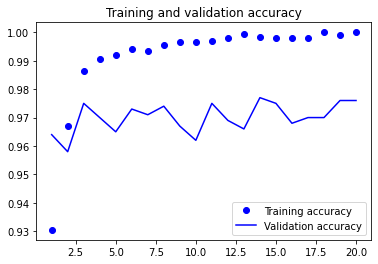

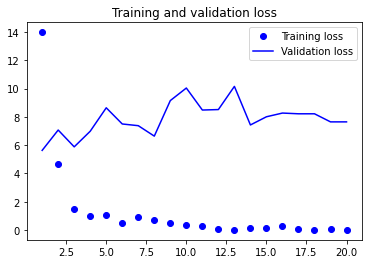

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Você atinge uma precisão de validação de cerca de 90% - muito melhor do que alcançou no
seção anterior com o pequeno modelo treinado do zero. Mas os gráficos também indicam
que você está superdimensionando quase desde o início, apesar de usar abandono com um grande
avaliar. Isso porque essa técnica não usa aumento de dados, que é essencial
para evitar overfitting com pequenos conjuntos de dados de imagens.

## Extração de recursos junto com aumento de dados

**Instanciar e congelar a base convolucional VGG16**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Imprimir a lista de pesos treináveis ​​antes e depois do congelamento**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adicionando aumento de dados e um classificador densamente conectado à base convolucional congelada**

O treinamento será bem mais pesado e requer GPU.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20, # tente com pelo menos 50
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 14s 194ms/step - loss: 32.4337 - accuracy: 0.8485 - val_loss: 32.8419 - val_accuracy: 0.8550
Epoch 2/20
63/63 [==============================] - 13s 195ms/step - loss: 12.1609 - accuracy: 0.9105 - val_loss: 10.6975 - val_accuracy: 0.9400
Epoch 3/20
63/63 [==============================] - 13s 195ms/step - loss: 9.6890 - accuracy: 0.9250 - val_loss: 20.5369 - val_accuracy: 0.8940
Epoch 4/20
63/63 [==============================] - 13s 201ms/step - loss: 8.9459 - accuracy: 0.9285 - val_loss: 8.1020 - val_accuracy: 0.9390
Epoch 5/20
63/63 [==============================] - 13s 194ms/step - loss: 5.8986 - accuracy: 0.9330 - val_loss: 7.0878 - val_accuracy: 0.9520
Epoch 6/20
63/63 [==============================] - 13s 191ms/step - loss: 5.7187 - accuracy: 0.9350 - val_loss: 8.5332 - val_accuracy: 0.9430
Epoch 7/20
63/63 [==============================] - 13s 198ms/step - loss: 5.3235 - accuracy: 0.9480 - val_loss: 5.1313 - val_accuracy: 0

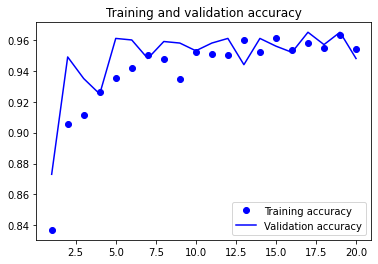

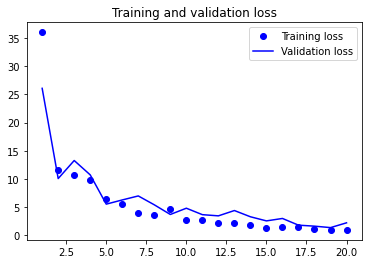

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Avaliação do modelo no conjunto de teste**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 9s 136ms/step - loss: 1.7206 - accuracy: 0.9585
Test accuracy: 0.959


## Fine-tuning de um modelo pré-treinado

Outra técnica amplamente utilizada para reutilização de modelo, complementar ao recurso
extração, é um ajuste fino. 

O ajuste fino consiste em descongelar alguns
as camadas superiores de uma base de modelo congelada usada para extração de recursos e treinamento conjunto
tanto a parte recém-adicionada do modelo (neste caso, o classificador totalmente conectado)
e essas camadas superiores. 

Isso é chamado de ajuste fino porque ajusta ligeiramente quanto mais
representações abstratas do modelo que está sendo reutilizado, a fim de torná-los mais relevantes
para o problema em questão.

![](https://drek4537l1klr.cloudfront.net/allaire/Figures/05fig15.jpg)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257 

Como já dito anteriormente, é necessário congelar a base de convolução de VGG16 para
ser capaz de treinar um classificador inicializado aleatoriamente no topo. 

Pelo mesmo motivo, é apenas
possível ajustar as camadas superiores da base convolucional, uma vez que o classificador no topo
já foi treinado. 

Se o classificador ainda não foi treinado, então o sinal de erro
propagação pela rede durante o treinamento será muito grande, e as representações
aprendidas anteriormente pelas camadas que estão sendo ajustadas serão destruídas. 

Assim, o as etapas para ajustar uma rede são as seguintes:

- 1 Adicione sua rede personalizada em cima de uma rede básica já treinada.
- 2 Congele a rede básica.
- 3 Treine a parte que você adicionou.
- 4 Descongele algumas camadas da rede de base.
- 5 Treine em conjunto essas camadas e a parte que você adicionou.

**Congelando todas as camadas até a quarta do final para o início**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning do modelo**

Agora você pode começar a ajustar a rede. Você fará isso com o otimizador RMSProp,
usando uma taxa de aprendizagem muito baixa. 

A razão para usar uma baixa taxa de aprendizagem é que
você deseja limitar a magnitude das modificações que você faz nas representações
das três camadas que você está ajustando. Atualizações muito grandes podem prejudicar essas representações.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 231ms/step - loss: 0.6471 - accuracy: 0.9700 - val_loss: 1.4233 - val_accuracy: 0.9600
Epoch 2/30
63/63 [==============================] - 15s 225ms/step - loss: 0.5240 - accuracy: 0.9695 - val_loss: 1.1999 - val_accuracy: 0.9620
Epoch 3/30
63/63 [==============================] - 15s 228ms/step - loss: 0.2995 - accuracy: 0.9780 - val_loss: 1.1042 - val_accuracy: 0.9620
Epoch 4/30
63/63 [==============================] - 15s 228ms/step - loss: 0.4390 - accuracy: 0.9680 - val_loss: 1.0714 - val_accuracy: 0.9620
Epoch 5/30
63/63 [==============================] - 15s 230ms/step - loss: 0.3866 - accuracy: 0.9750 - val_loss: 1.0414 - val_accuracy: 0.9640
Epoch 6/30
63/63 [==============================] - 15s 230ms/step - loss: 0.1314 - accuracy: 0.9870 - val_loss: 1.1102 - val_accuracy: 0.9590
Epoch 7/30
63/63 [==============================] - 15s 230ms/step - loss: 0.2499 - accuracy: 0.9830 - val_loss: 0.9225 - val_accuracy: 0.9610

Por que não ajustar mais camadas? Por que não ajustar toda a base convolucional?
Você poderia. Mas você precisa considerar o seguinte:

- Camadas anteriores na base convolucional codificam recursos reutilizáveis ​​mais genéricos,
enquanto as camadas superiores codificam recursos mais especializados. É mais útil  ajustar os recursos mais especializados, porque esses são os que precisam
ser reaproveitado em seu novo problema. Haveria retornos decrescentes em
ajuste fino das camadas inferiores.

- Quanto mais parâmetros você treina, mais corre o risco de overfitting.
A base convolucional tem 15 milhões de parâmetros, então seria arriscado
tente treiná-lo em seu pequeno conjunto de dados.

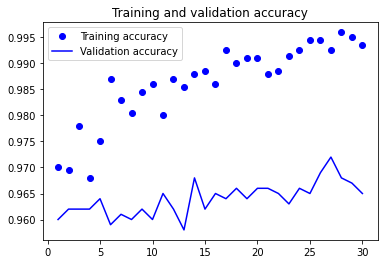

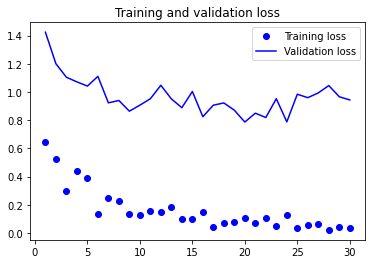

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 9s 137ms/step - loss: 0.9867 - accuracy: 0.9695
Test accuracy: 0.970


# Exercício


Explore o transfer learning em uma base de imagens de sua escolha.

## Referências

Livro Deep learning with python, François Chollet, capítulo 5.

https://livebook.manning.com/book/deep-learning-with-python/chapter-5/v-6/72
